## Imports

In [70]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A

# PIL for image operations
from PIL import Image

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

import os

## Visualize Dimensions of Images
This this is so we can better understand our data and helps us to decide which fixed image size to choose

In [71]:
# Plotting dimensions of ai-generated images

img_dir = "/Users/jacob/OneDrive/Desktop/Aletheia/Version2_4/Dataset/Fake/"

# Getting all images in the directory that contains ai-generated faces
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

# Loop through each image and extract its dimensions
for img_file in img_files:
    with Image.open(os.path.join(img_dir, img_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the dimensions of the images in a scatter plot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Fake Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

KeyboardInterrupt: 

In [72]:
# Plotting dimensions of real images

img_dir = "/Users/jacob/OneDrive/Desktop/Aletheia/Version2_4/Dataset/Real/"

# Getting all images in the directory that contains ai-generated faces
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

# Loop through each image and extract its dimensions
for img_file in img_files:
    with Image.open(os.path.join(img_dir, img_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the dimensions of the images in a scatter plot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Fake Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

KeyboardInterrupt: 

## Setup Neural Networks

In [73]:
class CNN(nn.Module):
    """
    A simpler CNN model architecture we used in the beginning.
    This model is fast, but its performance not always optimal.
    """
    def __init__(self, num_classes=2, dropout_prob=0.3):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Applying dropout with lower probability for convolutional layers
        self.dropout_conv = nn.Dropout(p=dropout_prob/3)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.dropout_conv(x)

        # Convolutional layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [74]:
class DeeperCNN(nn.Module):
    """
    A deeper CNN that's more complex than the original CNN.
    This model can detect more features but is also slower.
    """
    def __init__(self, dropout_prob=0.3):
        super(DeeperCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 2
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 3
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 4
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2) # A lower dropout probability for convolutional layers
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(128, 1)  # Final output layer for our binary classification problem
        )

    def feature_size(self):
        """
        Compute the size of flattened features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers.
        """
        return self.conv_layers(torch.zeros(1, 3, 256, 256)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [75]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels as if needed
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is an adjusted version of our DeeperDNN with slight adjustments and the addition of skip connections.
    This is the model architecture of our currently deployed face detection model.
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 256, 256)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [76]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Hyperparamters

In [77]:
# Define Hyperparameters
num_classes = 2
learning_rate = 0.0007
batch_size = 16
num_epochs = 24

## Data
- Load Data
- Split Data
- Apply transformations

In [78]:
class AlbumentationsTransform:
    """
    Class to transform images using the Albumentations library
    """
    def __init__(self, transform=None):
        self.transform = transform

    # Apply Albumentations transform to the input image and convert the result to a tensor.
    def __call__(self, img):
        # Convert image to numpy array if needed
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Convert augmented image to a tensor and normalize pixel values
        augmented = self.transform(image=img)
        img_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float() / 255.0
        return img_tensor

In [79]:
class TorchvisionBridge:
    """
    Bridge to convert Torchvision transforms into a format that can be used with the Albumentations library.
    """
    def __init__(self, transform):
        self.transform = transform

    # Apply torchvision transformations and convert the results to a numpy array
    def __call__(self, img):
        img = self.transform(img)
        return np.array(img)

In [80]:
# Define image transformations using both Torchvision and Albumentations libraries.

# Torchvision transforms
torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=2, translate=(0.025, 0.025)), # This helps making the model more robust on mobile (since users usually upload screenshots wich have a different positional format than the actual image), but a high value can weaken the accuracy on desktop (when used in the original image resultion).  
    transforms.Resize((256, 256))  # Resize all images to 256x256
])

torchvision_resize = transforms.Compose(
    transforms.Resize((256, 256))
)

# Albumentation transforms for data augmentation
augmentation = A.Compose([
    A.RandomBrightnessContrast(p=0.1),
    A.RandomGamma(p=0.15),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.04, rotate_limit=6, p=0.3),
    A.GaussNoise(p=0.1),
    A.GaussianBlur(p=0.1),
    A.PixelDropout(dropout_prob=0.013, p=0.35),
])

# Albumentation transforms for test data, where images are simply resized without additional transformation
test_augmentation = A.Compose([
    A.Resize(256, 256)
])

In [81]:
class CustomDataset(Dataset):
    """
    This Custom Dataset class is used to incorporate Torchvision and Albumentation transformations.
    """

    # Initialize CustomDataset Object
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    # Return number of samples in the dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Check if dataset is a subset and get the path and target accordingly
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        img = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            img = self.torchvision_transforms(img)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            img = self.albumentations_transform(img)
        
        return img, target

In [82]:
root_directory = '/Users/jacob/OneDrive/Desktop/Aletheia/Version2_4/Dataset/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(46)

# Split dataset into train, validation, and test sets
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=augmentation
)

val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Explore and Visualize Data

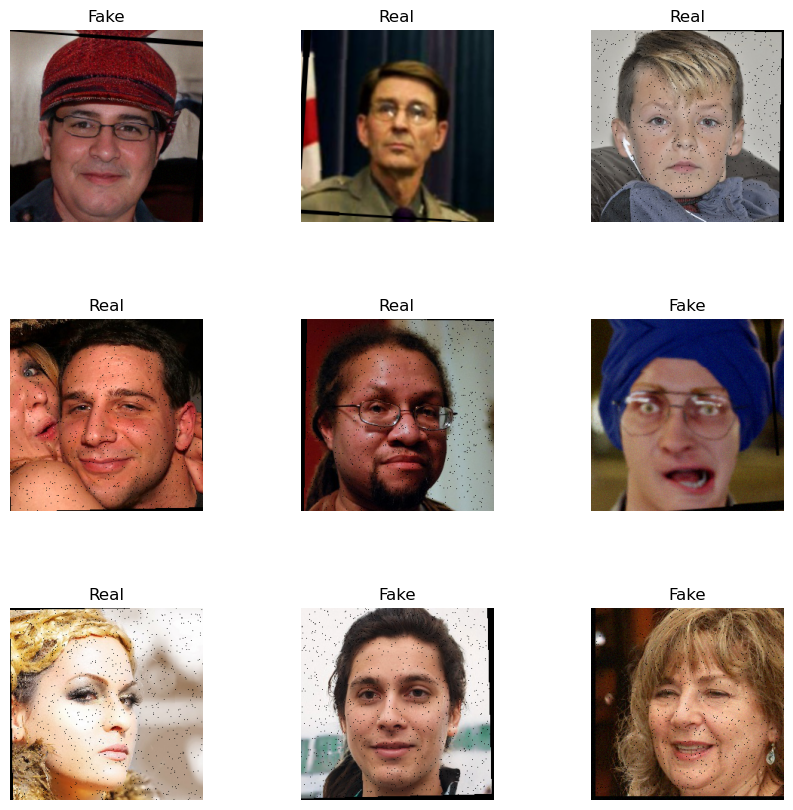

In [83]:
def show_img(dataloader, class_names, num_images=24):
    """Display a grid of images from a dataloader with their labels"""

    # Get a batch of images with labels from dataloader
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), 
                             subplot_kw={'xticks':[], 'yticks':[], 'frame_on':False})
    
    # Add spacing between the images
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    # Iterate over each axis in order to display images and associated labels
    for ax, img, lbl in zip(axes.ravel(), images, labels): 
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[lbl])
    
    plt.show()

# Using the function to display a few images from the training set
show_img(train_loader, class_names=full_dataset.classes)

## Training

### Prepare Training

In [84]:
# Set a random seed for reproducibility
torch.manual_seed(3)

# Initialize model and transfer it to the GPU (if available)
model = AdjustedResCNN().to(device)

In [85]:
# Use BCEWithLogitsLoss for our binary classification problem
loss_function = nn.BCEWithLogitsLoss()
# Define NAdam (a veriant of the Adam optimizer) as our optimizer
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
# Define learning rate scheduler to adjust our learning rate
scheduler = StepLR(optimizer, step_size=1, gamma=0.94)

In [86]:
# Initialize TensorBoard summary writer
writer = SummaryWriter(f'runs/Aletheia2_4')
step = 0

## Define Function for Determining Accuracy of Model

In [87]:
def check_accuracy(data_loader, model):
    """
    Calculate and print accuracy of the model on a given DataLoader
    """

    print(type(data_loader))
    correct = 0
    samples = 0

    # Set model to evaluation mode.
    model.eval()

    # Ensure no gradients are being computed during evaluation
    with torch.inference_mode():
        for x, y in data_loader:

            # Move the data and labels to the appropriate device
            x = x.to(device=device)
            y = y.to(device=device)

            # Make predictions with the model
            scores = model(x)

            # Convert logits to predictions
            preds = (torch.sigmoid(scores) > 0.45).squeeze(1).long() # The model generally perfomed better on real world problems with a threshold of 0.45

            # Update counters based on models predictions
            correct += (preds == y).sum().item()
            samples += preds.size(0)

        print(f'Got {correct} / {samples} correct with an accuracy of {float(correct)/float(samples)*100:.2f}%')

    # Set model back to train mode
    model.train()

    return correct, samples

## Train Model

In [88]:
# Initialize EmissionsTracker to tracker to monitor carbon emissions using the CodeCarbon library
carbon_tracker = EmissionsTracker(project_name="Aletheia2_4", log_level="critical")
carbon_tracker.start()

# Initialize tracking of correct predictions and total predictions
correct = 0
samples = 0

torch.manual_seed(3)

model = model.to(device)

# Set up log interval for recording metrics
metrics_interval = 250

# Start training
for epoch in range(num_epochs):

    # Reset accuracy counters at beginning of each epoch
    correct = 0
    samples = 0
    
    # Switch model to training mode
    model.train()

    # Train model on each batch of the train_loader and display progress in current epoch using tqdm
    for batch_index, (data, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Progress in epoch"):

        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float()) # Compute loss based on model's predictions

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Convert predictions to binary decisions
        preds = (torch.sigmoid(scores) > 0.5).float()

        # Update accuracy counters
        correct += (preds == targets).sum().item()
        samples += preds.size(0)
        # Calculate accuracy as percentage
        accuracy = 100 * correct / samples


        if batch_index % metrics_interval == 0:
            # Log metrics to TensorBoard
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_index)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_index)
            # Print metrics
            print("Epoch: ", epoch)
            print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')


    # Print accumulated accuracy for epoch
    print("Epoch: ", epoch)
    print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')
    scheduler.step()

    # Evaluate the model on validation set after each epoch
    print("Checking accuracy on Test Data")
    correct_test, samples_test = check_accuracy(val_loader, model)
    test_accuracy = 100 * float(correct_test) / float(samples_test)

    # Log test accuracy to TensorBoard
    writer.add_scalar('Test Accuracy', test_accuracy, epoch) 

    # Save state of model after each epcoh
    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/SyntheticEye/StateDicts/Aletheia/al2_4model1_epoch_{epoch}_correct{correct}.pth')

# Stop EmmisionsTracker
emissions = carbon_tracker.stop()

# Display total carbon emissions
print(f"Emissions: {emissions:.10f} kgCO2eq")

Progress in epoch:   0%|          | 0/14889 [00:00<?, ?it/s]

Epoch:  0
Got 8 / 16 correct with an accuracy 50.00% on training data.


KeyboardInterrupt: 

## Test state_dict of Trained Model

In [89]:
model = AdjustedResCNN().to(device)

# Create a dummy input and perform a forward pass to create the fc1 layer
sample_input = torch.randn(1, 3, 256, 256).to(device)
model(sample_input)

# Specify path to the trained model weights
model_path = "/Users/jacob/OneDrive/Desktop/SyntheticEye/StateDicts/Aletheia/al2_4model1_epoch_19_correct233899.pth"

# Load trained weights into the model
model.load_state_dict(torch.load(model_path))

model = model.to(device)

In [90]:
# Check accuracy of trained model on the test data
check_accuracy(test_loader, model)

<class 'torch.utils.data.dataloader.DataLoader'>


KeyboardInterrupt: 

### Test on Specific Source

In [104]:
# Load the new dataset
new_root_directory = "/Users/jacob/OneDrive/Desktop/SyntheticEye/EvalData/Aletheia/real_faces/"
new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Apply data augmentation and images transformations
new_test_dataset = CustomDataset(
    new_full_dataset, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on new dataset
check_accuracy(new_test_loader, model)

<class 'torch.utils.data.dataloader.DataLoader'>
Got 45 / 50 correct with an accuracy of 90.00%


(45, 50)

### Try on individual Image

In [ ]:
# Load model that will be used to predict individual images
model_path = "/Users/jacob/OneDrive/Desktop/SyntheticEye/StateDicts/Aletheia/al2_4model1_epoch_19_correct233899.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

AdjustedResCNN(
  (conv_layers): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.06, inplace=False)
      )
      (residual): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (block): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.06, inplace=False)
      )
      (residual): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResB

In [103]:
def single_image_transforms():
    """
    Combine torchvision and albumentations transforms for an individual image
    """

    tv_transform = tv_transform = TorchvisionBridge(torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128))]))
    alb_transform = AlbumentationsTransform(test_augmentation)
    
    # Apply both transformations to the given image
    def combined_transforms(img):
        img = tv_transform(img)
        return alb_transform(img)
    
    return combined_transforms

In [102]:
def predict_single_image(img_path, model, transforms):
    """
    Predicts the label for a single image using trained model.
    """
    
    # Load image
    img = Image.open(img_path).convert("RGB")

    # Apply combined transforms
    img_tensor = transforms(img).unsqueeze(0).to(device)

    # Set model to evaluation mode and predict image
    model.eval()
    with torch.inference_mode():
        scores = model(img_tensor)
        probability = torch.sigmoid(scores).squeeze().item()

    # Set the model back to training mode
    model.train()

    # Return computed probability
    return probability

In [101]:
img_path = "/Users/jacob/OneDrive/Desktop/SyntheticEye/EvalData/Aletheia/ai.jpg"

# Use predict_single_imge function to predict a single image
predicted_label = predict_single_image(
    img_path, 
    model,
    # Use Albumentations to transform the image as needed
    AlbumentationsTransform(test_augmentation)
)

# Print prediction for the given image
print(f"Predicted probability for the image: {predicted_label}")

Predicted probability for the image: 1.4587372718717802e-15


In [98]:
def display_folder_images(folder, model, combined_transforms, num_images=50):
    """
    Display images from a parent folder along with their correct label and predicted probability.
    This helps us to understand the model
    """
    
    # Possible classes of images
    classes = ['real', 'fake']
    images = []

    # Iterate through classes and get image paths
    for label in classes:
        class_folder = os.path.join(folder, label)
        # Collect every image file path from the current class directory
        img_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
        # Append to all_images list with their label
        images.extend([(img, label) for img in img_files[:num_images]])

    # Initialize grid of subplots to display images
    fig, axis = plt.subplots(5, len(images) // 5, figsize=(25, 15))

    # Display each image with label and predicted probability
    for i, (img_path, correct_label) in enumerate(images):
        # Get predicted probability
        predicted_probability = predict_single_image(img_path, model, combined_transforms)
        
        # Load image with PIL
        img = Image.open(img_path)

        # Display image
        row = i // (len(images) // 5)  
        column = i % (len(images) // 5) 
        axis[row, column].imshow(img)
        axis[row, column].set_title(f"Correct: {correct_label}\nPred: {predicted_probability:.3f}")
        axis[row, column].axis("off")
    
    plt.tight_layout()
    plt.show()

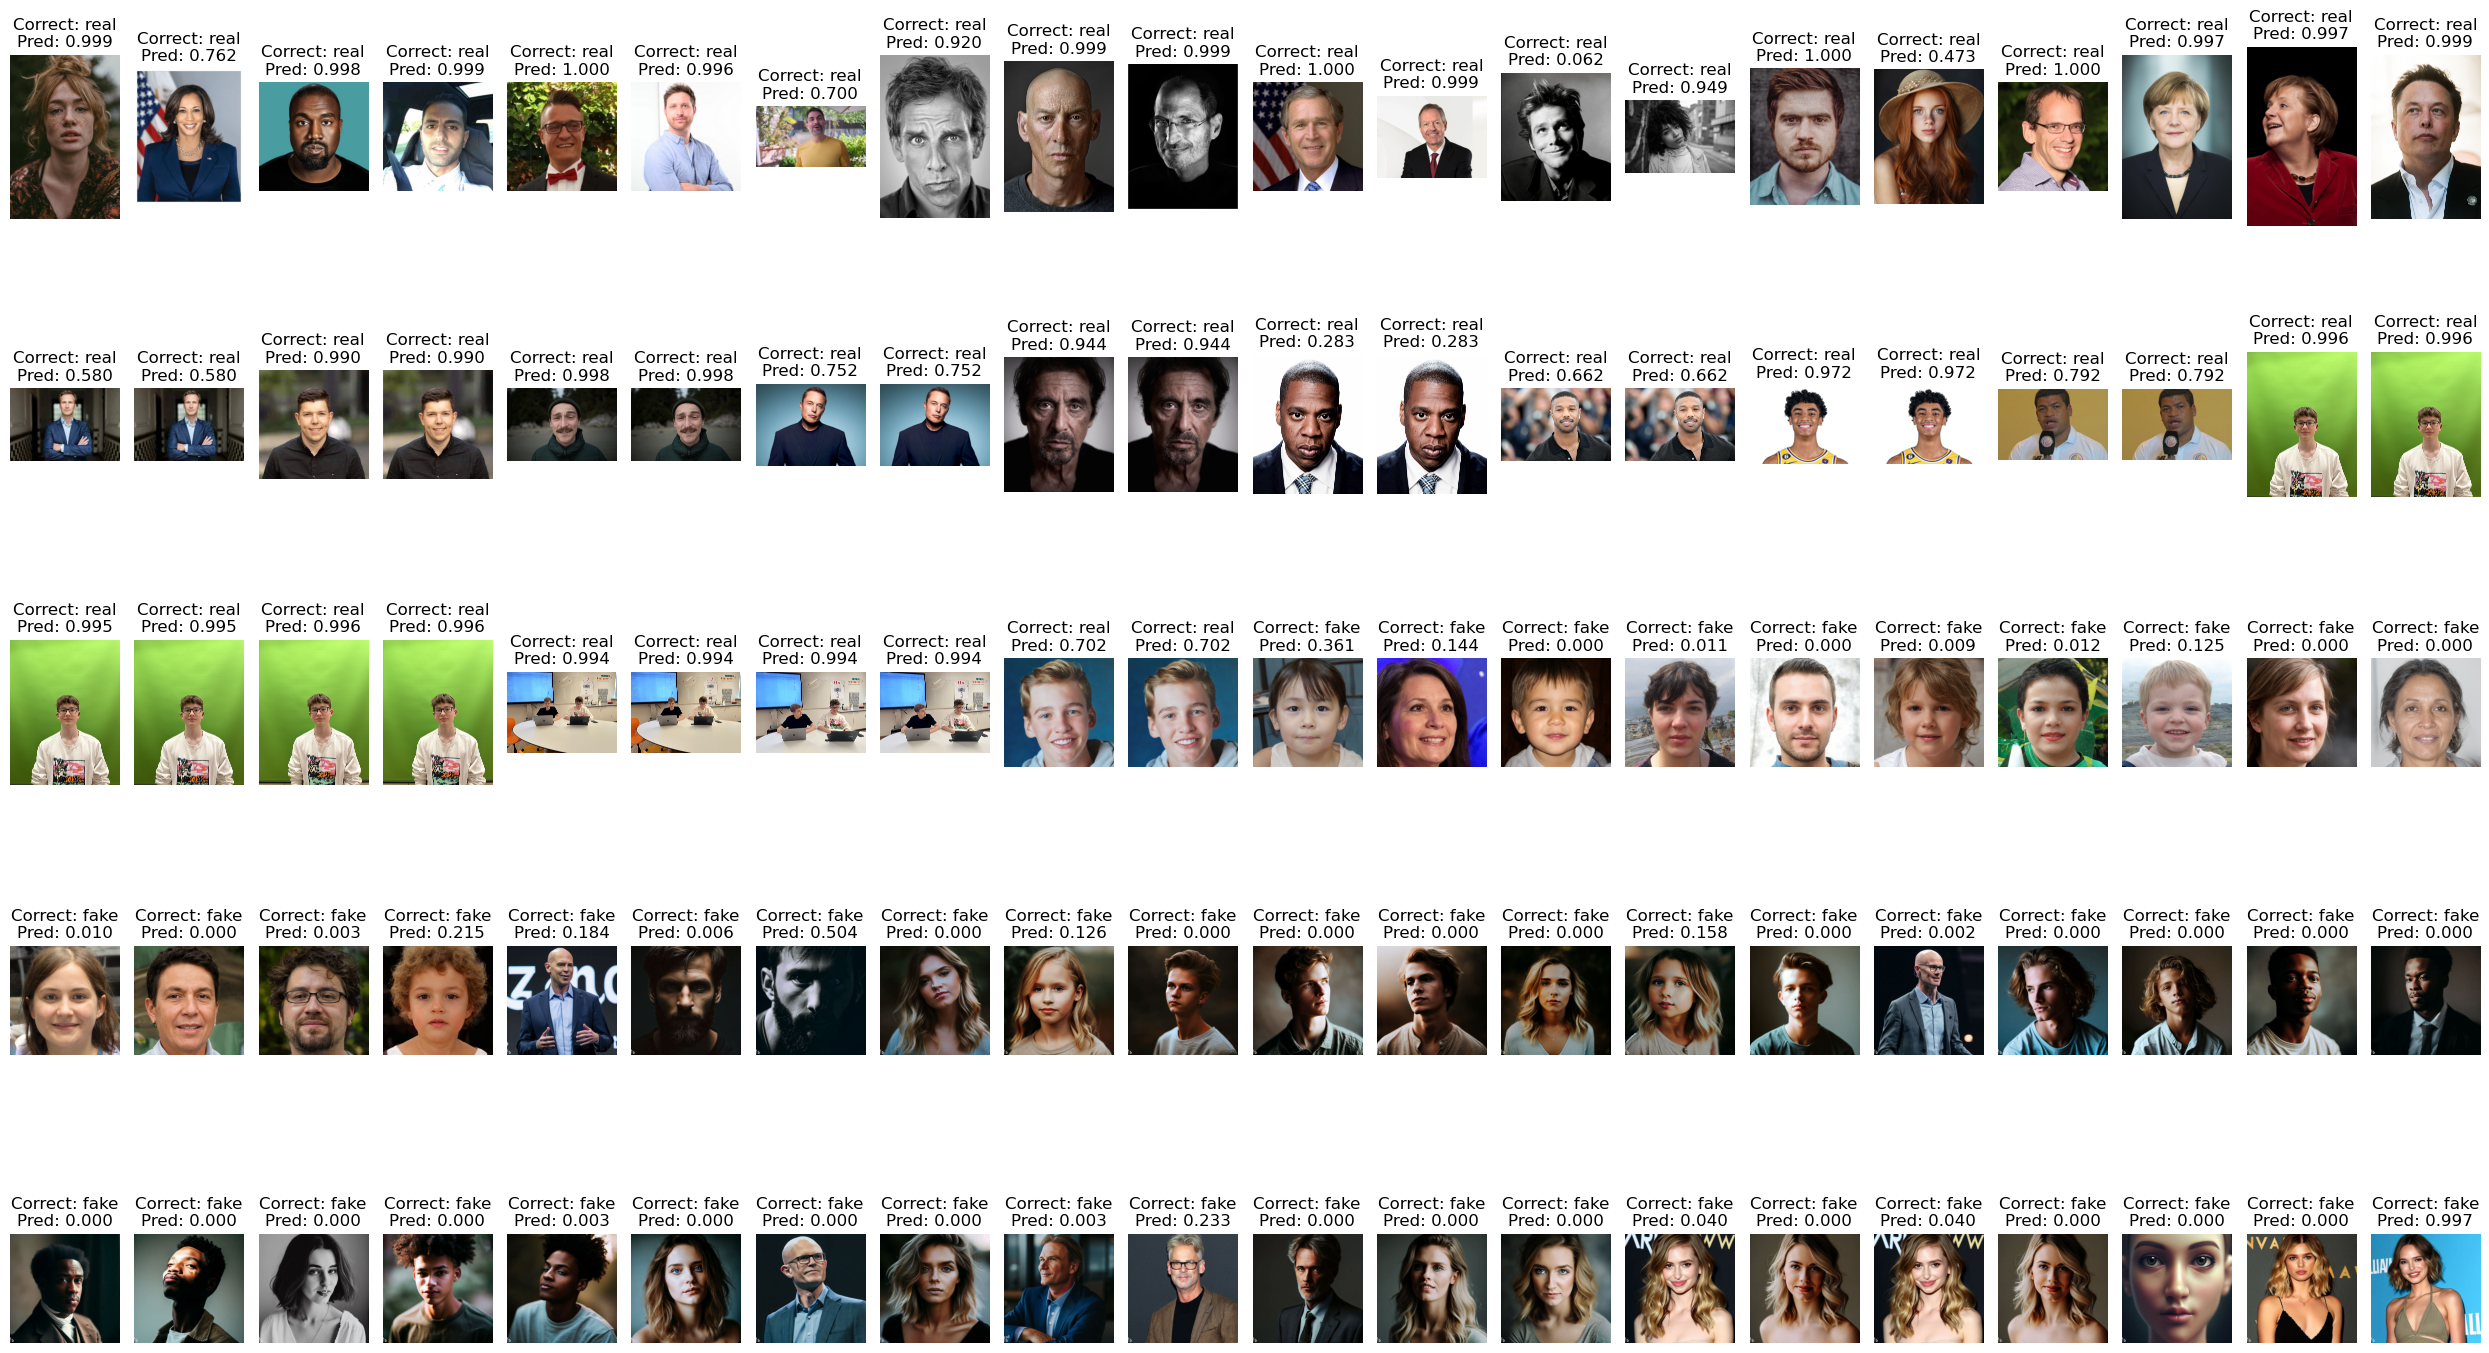

In [99]:
# Load combined transformations and display images with their predicted probabilities
combined_transforms = single_image_transforms()
display_folder_images("/Users/jacob/OneDrive/Desktop/SyntheticEye/EvalData/Aletheia/MultipleEval/", model, combined_transforms)